In [1]:
import matplotlib.pyplot as plt
import numpy as np
import random
from itertools import combinations
import operator
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score
import pickle as pkl
import seaborn as sns
random.seed(1)
np.random.seed(0)
sns.set_theme()

# Train Data

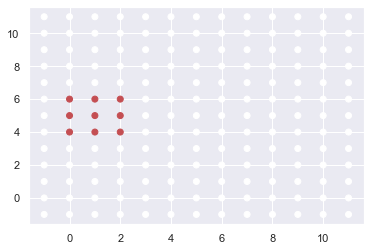

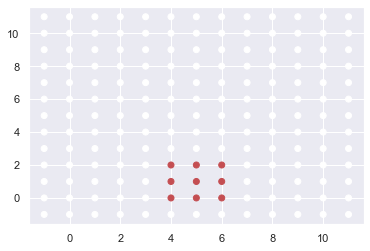

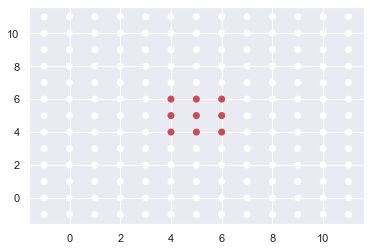

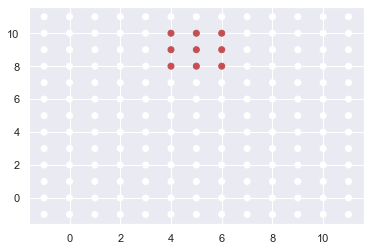

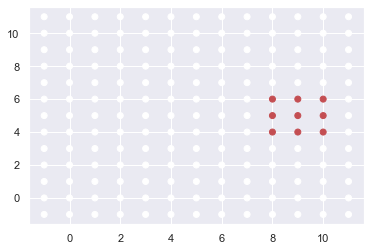

In [2]:
S1_pos = [[0,4],[0,5],[0,6],[1,4],[1,5],[1,6],[2,4],[2,5],[2,6]]
S2_pos = [[4,0],[4,1],[4,2],[5,0],[5,1],[5,2],[6,0],[6,1],[6,2]]
S3_pos = [[4,4],[4,5],[4,6],[5,4],[5,5],[5,6],[6,4],[6,5],[6,6]]
S4_pos = [[4,8],[4,9],[4,10],[5,8],[5,9],[5,10],[6,8],[6,9],[6,10]]
S5_pos = [[8,4],[8,5],[8,6],[9,4],[9,5],[9,6],[10,4],[10,5],[10,6]]
SX_pos = [S1_pos,S2_pos,S3_pos,S4_pos,S5_pos,]

X = []
Y = []

for SX in SX_pos:
    x = []
    y = []
    for i in range(-1,12):
        for j in range(-1,12):
            x.append([i,j])
            if [i,j] in SX:
                y.append(1)
            else:
                y.append(-1)
    x = np.asarray(x)
    y = np.asarray(y)
    X.append(x)
    Y.append(y)
colormap = np.array(['b','r', 'w'])
for x,y in zip(X,Y):
    plt.scatter(x[:,0],x[:,1],c=colormap[y])
    plt.show()

# Test Data

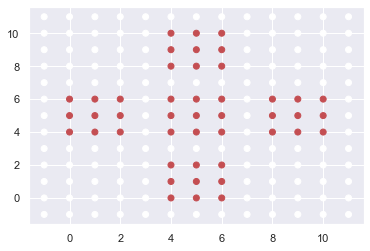

In [3]:
X_pos = S1_pos+S2_pos+S3_pos+S4_pos+S5_pos
X_test = []
Y_test = []
for i in range(-1,12):
    for j in range(-1,12):
        X_test.append([i,j])
        if [i,j] in X_pos:
            Y_test.append(1)
        else:
            Y_test.append(-1)
X_test = np.asarray(X_test)
Y_test = np.asarray(Y_test)
plt.scatter(X_test[:,0],X_test[:,1],c=colormap[Y_test])
plt.show()

# Helper Functions

In [4]:
#ADALINE
def ada(n_iters, learning_rate,w, x, y):
    for _ in range(n_iters):
        z = np.dot(x,w[:-1]) + w[-1]
        delta = y - z
        w[:-1]+=learning_rate*np.dot(delta,x)
        w[-1] += learning_rate*delta.sum()
        y_pred = -1
        if z>=0:
            y_pred = 1
        if y_pred == y:
            break
    return w

class neuron:
    def __init__(self, layer = 0, input_count = 2):
        self.w = []
        self.z = 0
        self.visited = 0
        self.input_count = input_count
        if layer ==0:
            for i in range(input_count+1):
                self.w.append(np.random.normal(loc=0.0, scale=0.01))
        elif layer == 2:
            for i in range(input_count):
                self.w.append(0.5)
            self.w.append(0.2 - 0.5*input_count)
        else:
            for i in range(input_count):
                self.w.append(0.5)
            self.w.append(0.5*(input_count-1))
    def net_input(self,x):
        self.z = np.dot(x,self.w[:-1]) + self.w[-1]
    def predict(self):
        self.y_pred = 1 if self.z>=0 else -1
        return self.y_pred

# Network initialization

In [7]:
max_iter = 10000000

layer_1, layer_2 = [],[]
neurons_1 = 20
neurons_2 = 5
for i in range(neurons_1):
    n = neuron(0,2)
    layer_1.append(n)
for i in range(neurons_2):
    n = neuron(2,4)
    layer_2.append(n)
out = neuron(1,5) 

# Madaline Learning Algorithm Implementation

In [149]:
n_epochs = 20000
f1 = {}
acc = {}
for epoch in range(n_epochs):
    
    print(epoch)
#     for p in layer_1:
#         p.visited = 0
    for component,x,y_true in zip(range(len(layer_2)),X,Y):
        i=0
        itr = 0
        while(i<x.shape[0] and itr<max_iter): #X.shape[0]
            itr += 1
            #print(itr,i)
            y_pred1 = []
            #Only activate 4 neurons belonging to one component
            for n in layer_1[4*component:4*(component+1)]:
                n.net_input(x[i])
                y_pred1.append(n.predict())
            #Check for each component
            layer_2[component].net_input(y_pred1)
            y = layer_2[component].predict()
            
            if y == y_true[i]:
                i+=1
                continue
            else:
                k=0
                Z = []
                for k in range(4*component,4*(component+1)):
                    Z.append([layer_1[k].visited, abs(layer_1[k].z), k])
                #Sort by least visited then smallest affine value
                Z = sorted(Z, key=lambda x: (x[0], x[1]))
                
                flag =0
                
                for fu in range(0,len(Z)+1): #POWER SET to generate all possible combinations
                    for element in combinations(Z,fu):
                        for j in element:
                            layer_1[j[2]].visited += 1
                            y_pred1[j[2]%4] *= -1
                        
                        layer_2[component].net_input(y_pred1)
                        y1 = layer_2[component].predict()
                        if y1 == y_true[i]:
                            for j in element:
                                layer_1[j[2]].w = ada(1000, 0.01, layer_1[j[2]].w, x[i], y_pred1[j[2]%4])
                            #i=0   #To fix all errors in one epoch
                            flag =1
                            break
                        else:
                            for j in element:
                                y_pred1[j[2]%4] *= -1
                    if flag == 1:
                        break 
                i+=1
#         for p in layer_1:
#             print(p.visited)
        y=[]
        for xi in x:
            y_pred = []
            #Only activate 4 neurons belonging to one component
            for n in layer_1[4*component:4*(component+1)]:
                n.net_input(xi)
                y_pred.append(n.predict())
            #Check for each component
            layer_2[component].net_input(y_pred)
            y.append(layer_2[component].predict())
        #print(y)
        print("F1 FOR COMPONENT ", component,": ",f1_score(y_true,y)*100)


0
F1 FOR COMPONENT  0 :  100.0
F1 FOR COMPONENT  1 :  100.0
F1 FOR COMPONENT  2 :  69.23076923076924
F1 FOR COMPONENT  3 :  100.0
F1 FOR COMPONENT  4 :  100.0
1
F1 FOR COMPONENT  0 :  100.0
F1 FOR COMPONENT  1 :  100.0
F1 FOR COMPONENT  2 :  60.0
F1 FOR COMPONENT  3 :  100.0
F1 FOR COMPONENT  4 :  100.0
2
F1 FOR COMPONENT  0 :  100.0
F1 FOR COMPONENT  1 :  100.0
F1 FOR COMPONENT  2 :  69.23076923076924
F1 FOR COMPONENT  3 :  100.0
F1 FOR COMPONENT  4 :  100.0
3
F1 FOR COMPONENT  0 :  100.0
F1 FOR COMPONENT  1 :  100.0
F1 FOR COMPONENT  2 :  66.66666666666666
F1 FOR COMPONENT  3 :  100.0
F1 FOR COMPONENT  4 :  100.0
4
F1 FOR COMPONENT  0 :  100.0
F1 FOR COMPONENT  1 :  100.0


KeyboardInterrupt: 

# Dump weights for each layer

In [109]:
# with open('layer_1_100', "wb") as f:
#     pkl.dump(layer_1, f)
# with open('layer_2_100', "wb") as f:
#     pkl.dump(layer_2, f)
# with open('out_100', "wb") as f:
#     pkl.dump(out, f)

# Load best performing weights

In [5]:
with open('layer_1_best', "rb") as f:
    l1 = pkl.load(f)
with open('layer_2_best', "rb") as f:
    l2 = pkl.load(f)
with open('out_best', "rb") as f:
    o = pkl.load(f)

# Forward propogate test data for evaluation

In [8]:
y_pred = []
for i,x in zip(range(len(X_test)),X_test):
    y_pred1 =[]
    for n in l1:
        n.net_input(x)
        y_pred1.append(n.predict())
    y_pred2 = []
    for idx,n in zip(range(len(l2)),l2):
        n.net_input(y_pred1[4*idx:4*(idx+1)])
        y_pred2.append(n.predict())
    out.w[-1] = 2.0
    out.net_input(y_pred2)
    y_pred.append(out.predict())

# Results

In [9]:
print("Accuracy of function: ",accuracy_score(Y_test,y_pred) * 100)
print("F1 score of function", f1_score(Y_test,y_pred) * 100 )

Accuracy of function:  100.0
F1 score of function 100.0


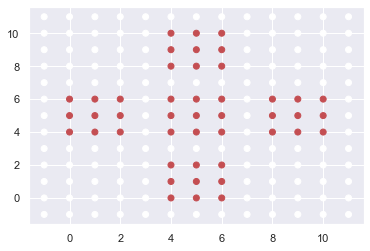

In [10]:
plt.scatter(X_test[:,0],X_test[:,1],c=colormap[y_pred])
plt.show()